# Exploration of the housing prices data set

An opportunity to pracitce basic ML techniques From https://www.kaggle.com/c/house-prices-advanced-regression-techniques.

https://www.kaggle.com/code/lucabasa/houseprice-end-to-end-project/notebook is an excellent write-up on how to go about this.

## Import the library

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

## Load the dataset


In [17]:
df = pd.read_csv("data_train.csv")
df = df.drop('Id', axis=1)  # Drop useless Id column (it is not a predictor)
print("Full train dataset shape is {}".format(df.shape))
label = "SalePrice"    # The column that contains the label to predict.

Full train dataset shape is (1460, 80)


## Target Distribution

Let look at the distribution of the target label, SalePrice.

Original SalePrice
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Skewness: 1.882876


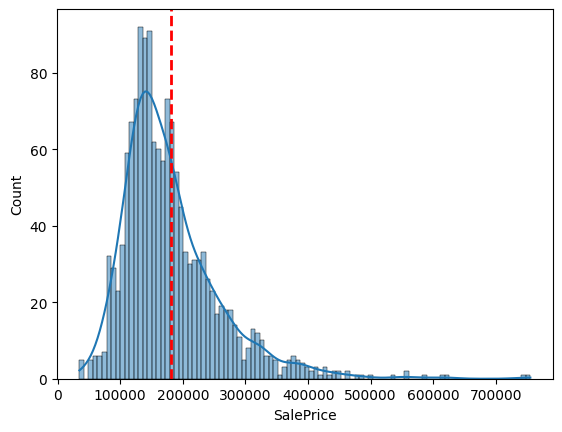

Log transformed SalePrice
count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64
Skewness: 0.121335


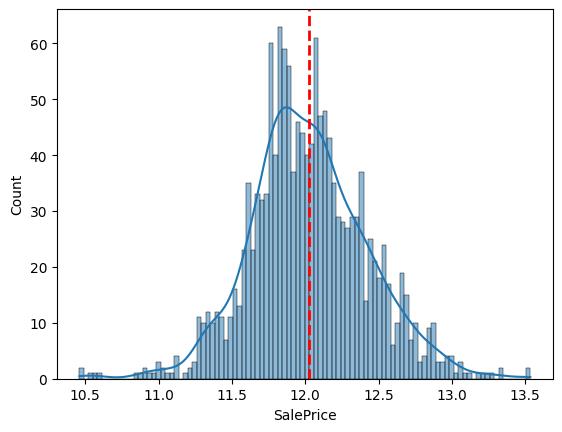

In [18]:
for name, data in zip ([f"Original {label}", f"Log transformed {label}"], [df[label], np.log(df[label])]):
    print (name)
    sns.histplot(data=data, bins=100, kde=True)
    plt.axvline(data.mean(), color='red', linestyle='dashed', linewidth=2)
    print(data.describe())                 # Includes mean and sd (the first and second moments - see https://en.wikipedia.org/wiki/Standardized_moment)
    print("Skewness: %f" % data.skew())    # Third moment measures symmetry (0 = symmetric, positive = right-skewed, negative = left-skewed)
    plt.show()

## Null counts across all features

Percent nulls per feature (out of 1460 samples):
PoolQC          99.52
MiscFeature     96.30
Alley           93.76
Fence           80.75
MasVnrType      59.72
FireplaceQu     47.26
LotFrontage     17.73
GarageYrBlt      5.54
GarageType       5.54
GarageFinish     5.54
GarageQual       5.54
GarageCond       5.54
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.54
Electrical       0.06
dtype: float64

The test data has the following additional columns with nulls:
MSZoning        0.27
Utilities       0.13
Exterior1st     0.06
Exterior2nd     0.06
BsmtFinSF1      0.06
BsmtFinSF2      0.06
BsmtUnfSF       0.06
TotalBsmtSF     0.06
BsmtFullBath    0.13
BsmtHalfBath    0.13
KitchenQual     0.06
Functional      0.13
GarageCars      0.06
GarageArea      0.06
SaleType        0.06
dtype: float64


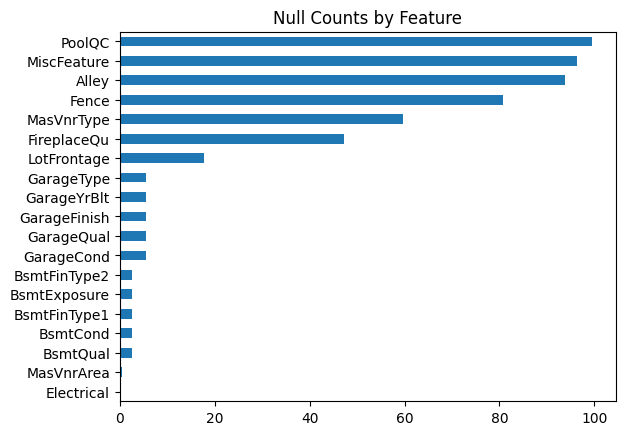

In [57]:
# Show null counts by feature
def show_nulls (dataframe, test_dataframe=None):
    null_counts = dataframe.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    null_counts = null_counts * 10000 / dataframe.shape[0] // 1 / 100    # Convert to percentage with 2 decimal places
    if null_counts.empty:
        print ('No nulls found')
        return
    print (f"Percent nulls per feature (out of {len(dataframe)} samples):")
    null_counts = null_counts.sort_values(ascending=True)
    null_counts.plot.barh()
    plt.title('Null Counts by Feature')
    null_counts = null_counts.sort_values(ascending=False)
    print (null_counts)

    if test_dataframe is None:
        return
    test_dataframe.drop(dataframe.isnull().sum()[dataframe.isnull().sum() > 0].index, axis=1, inplace=True)    # Drop columns that have nulls in the original dataset
    additional_nulls = test_dataframe.isnull().sum()/test_dataframe.shape[0] * 10000 // 1 / 100     # Additional nulls in test data, as a percentage with 2 decimal places
    if additional_nulls.empty:
        return
    print ("\nThe test data has the following additional columns with nulls:")
    print (additional_nulls[additional_nulls > 0])

show_nulls(df, pd.read_csv("data_test.csv"))


## Numerical data overview

We will now take a look at how the numerical features are distributed, and their correlation to the target.

Correlation of numeric features to SalePrice by descending absolute value:

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass      -0.084284
OverallCond     -0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath  

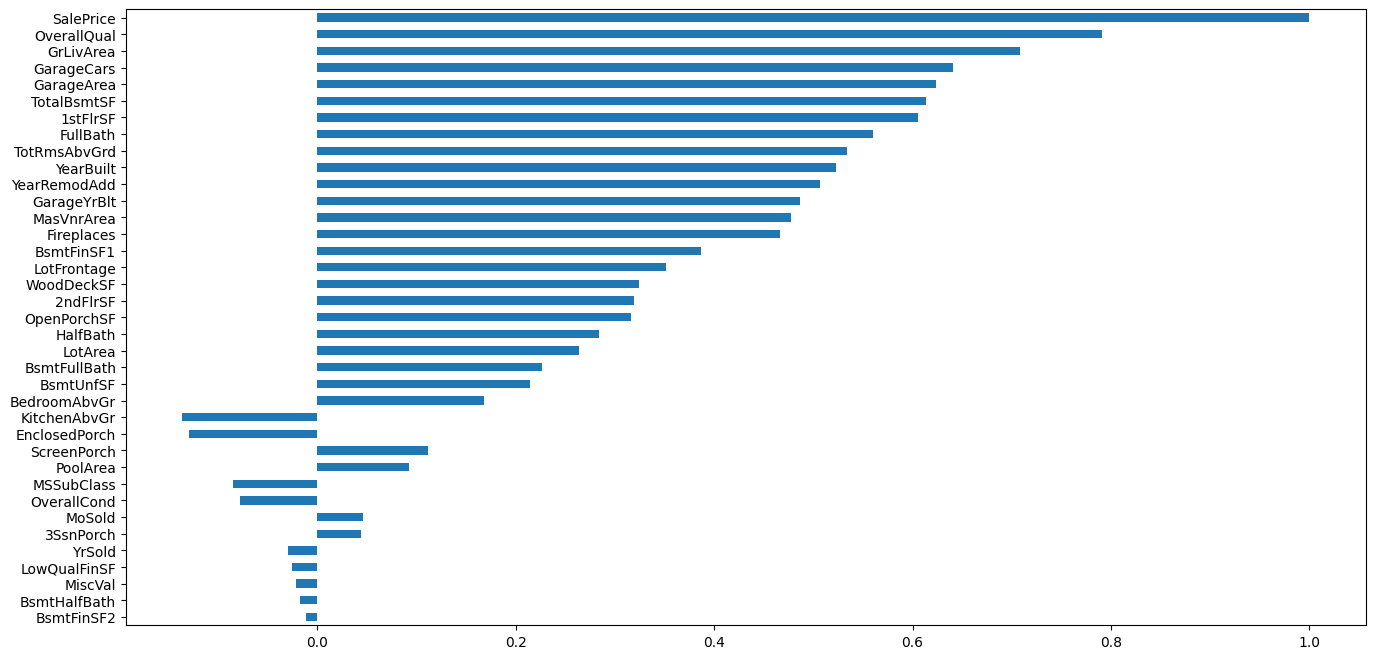

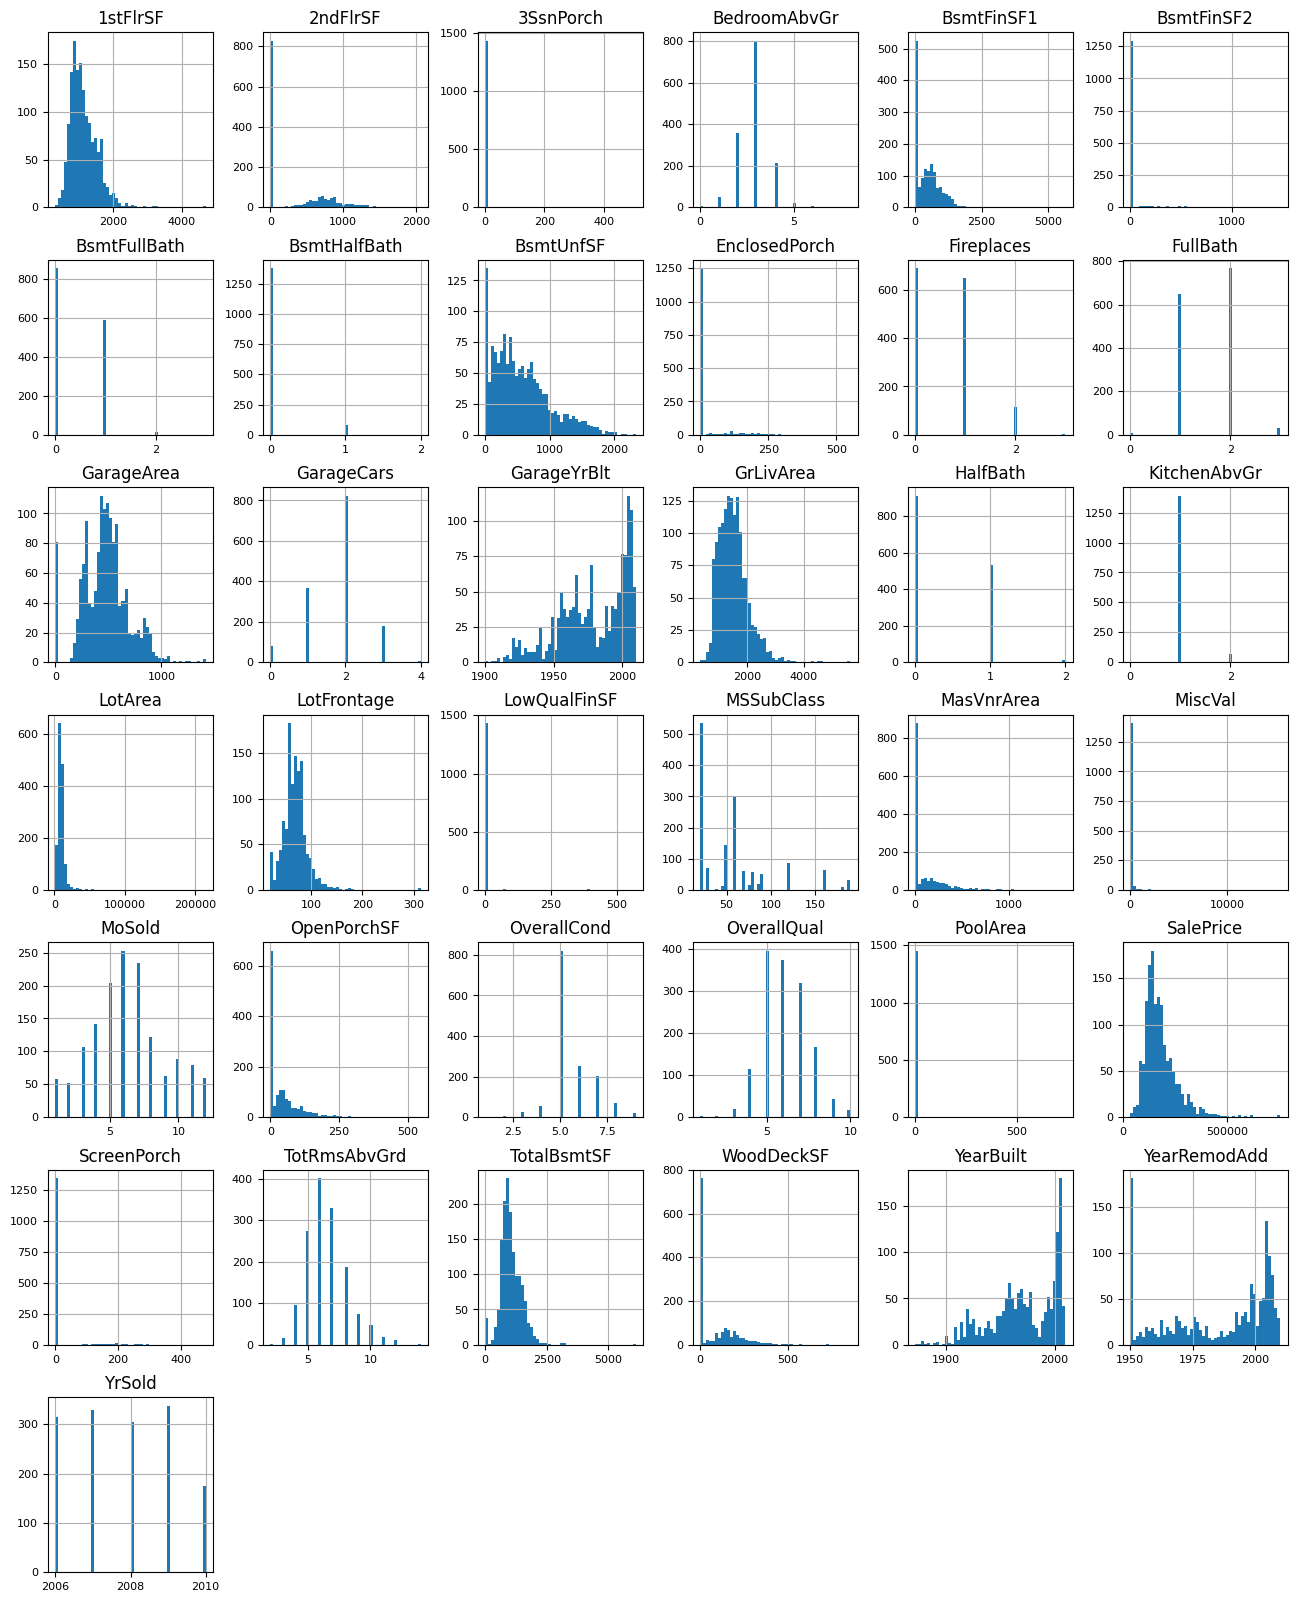

In [58]:
df_num = df.select_dtypes(include=[np.number])  # Numeric features

corr = df_num.corr()
print (f"Correlation of numeric features to {label} by descending absolute value:\n")
corr = corr.sort_values(label, key=lambda x: -abs(x))
print (corr[label])

# Plot correlations against label, sorted by absolute value
corr = corr.sort_values(label, key=lambda x: abs(x))
corr[label].plot.barh(figsize=(16, 8));

# Plot histograms after alphabetical reordering (to make it easier to find columns later)
df_num = df_num.reindex(sorted(df_num.columns), axis=1)
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## Discreet numeric data analysis

Note - the black trend lines below are, in fact lines, but may look peicewise linear on some graphs because the x values are not always evenly spaced.
Some observations:
* PoolArea, MoSold, YrSold, and MSSubClass are useless predictors and should be removed.
* Some of the bathrooms metrics have unexpected slopes; perhaps need to be combined to be more meaningful
* KitchenAbvGr (# kitchens) spikes at 1 and goes down on both sides. Maybe better to just try a single value here (1 kitchen or not?)
* OverallCond - trend line says better condition = lower price. Mostly it trends up, but condition 5 has the most, and it is higher than 6-8. This needs fixing at least for the linear model.

Analyzing discreet numeric features (less than 20 unique values)
No nulls found


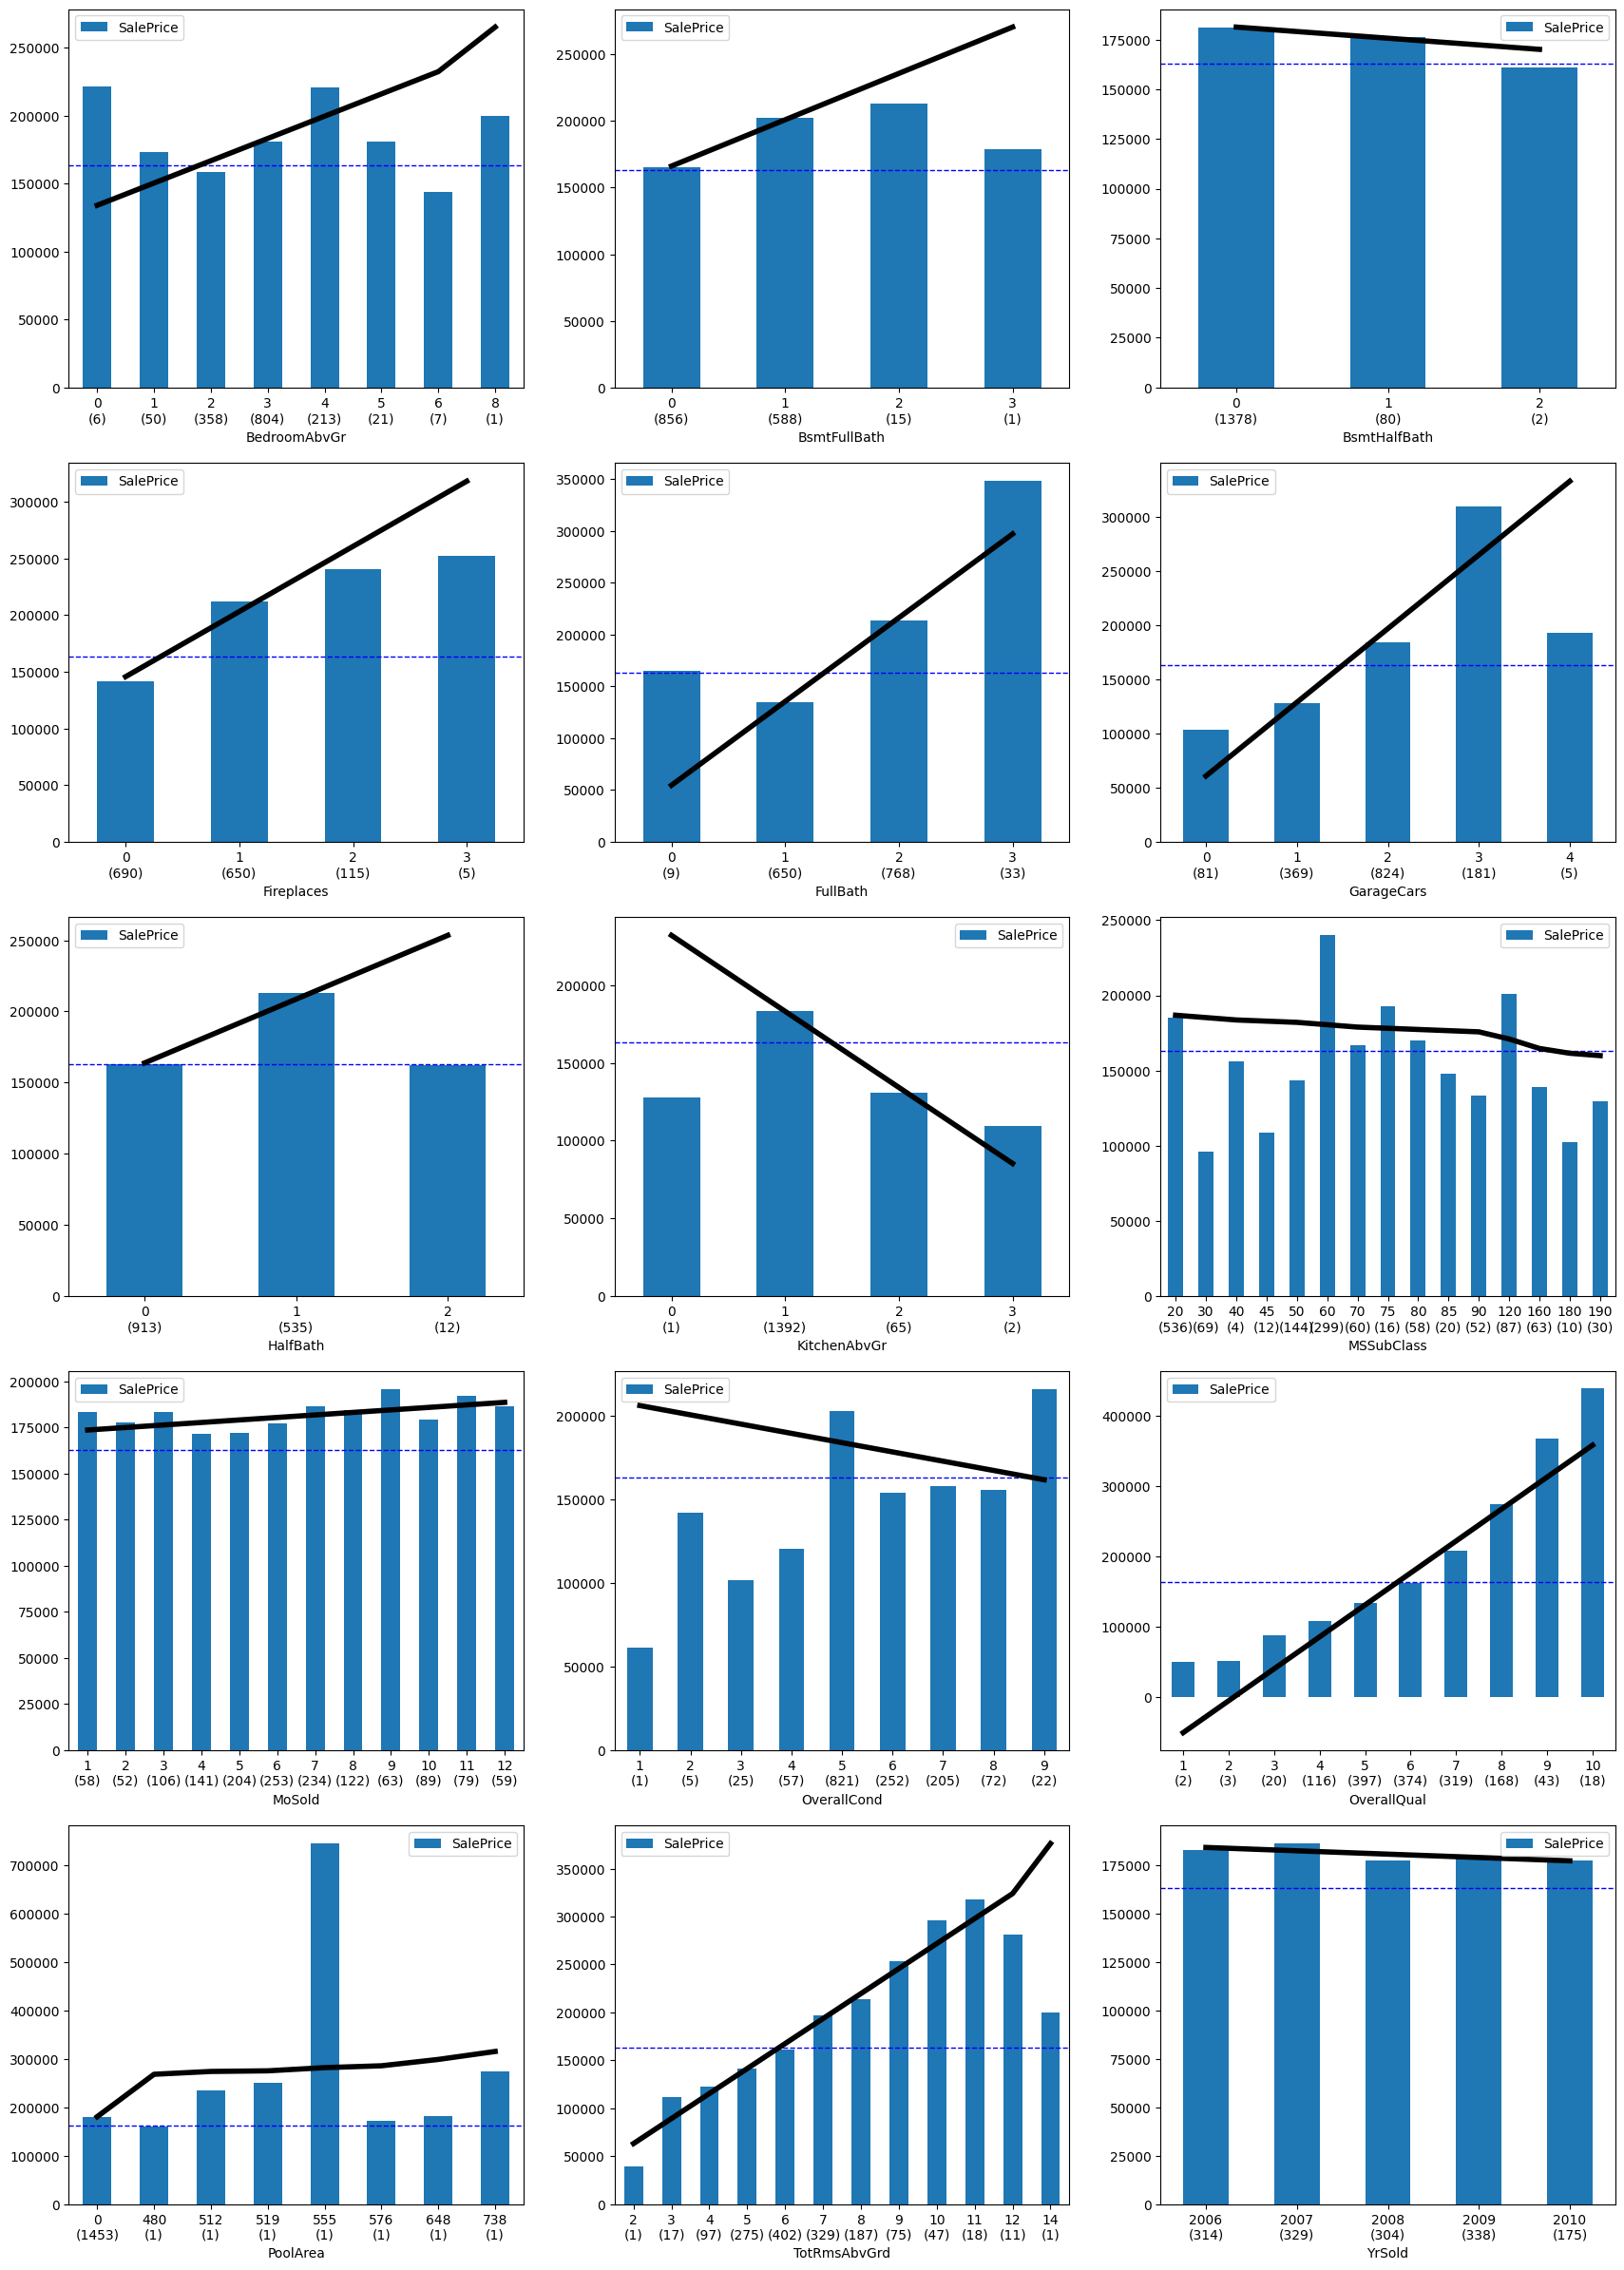

In [124]:
def analyze_discrete_numeric_features (dataframe, max_unique_values=20):
    print (f"Analyzing discreet numeric features (less than {max_unique_values} unique values)")

    df_num = dataframe.select_dtypes(include=[np.number])
    df_num_discrete = df_num[[col for col in df_num.columns if df_num[col].nunique() < max_unique_values]]         # Discrete numeric features (only has a small number of values)
    df_num_discrete = df_num_discrete.reindex(sorted(df_num_discrete.columns), axis=1)      # Alphebetize columns for the plots below

    show_nulls(df_num_discrete)

    # For each feature in df_num_discreet, plot the feature value vs the average SalePrice for that value
    ncols = 3
    nrows = int(np.ceil(len(df_num_discrete.columns)/ncols))
    _, axes = plt.subplots(nrows, ncols, figsize=(ncols*7, nrows*6))
    for i, feature in enumerate(df_num_discrete.columns):
        if nrows == 1:
            ax = axes[i]
        else:
            ax = axes[i//ncols, i%ncols]
        price_by_feature = dataframe[[feature, label]].groupby(feature).mean()
        price_by_feature.plot.bar(ax=ax)
        counts = dataframe[feature].value_counts()
        ax.set_xlabel(feature)
        xlables = []
        for i in range(len(price_by_feature.index)):
            value = price_by_feature.index[i]
            count = counts[value]
            xlables.append(f"{value}\n({count})")
        ax.set_xticklabels(xlables, rotation=0)

        # Show the (common) mean sales price and (graph-specific) trend line
        ax.axhline(dataframe[label].median(), color='blue', linestyle='dashed', linewidth=1) # Median price

        df = dataframe[[feature, label]].dropna()
        m, b = np.polyfit(df[feature], df[label], 1)
        x = np.sort(df[feature].unique())
        y = m*x + b
        x = np.argsort(x)   # Plot doesn't work without this (thanks ChatGPT!)
        ax.plot(x, y, color='black', linewidth=4) # Trend line
        
    plt.show()

analyze_discrete_numeric_features (df)

## Continuous numeric data analysis

Observations:
* These features are useless and should be dropped: BsmtFinSF2, EnclosedPorch, LowQualFinSF, MiscVal
* LotFrontage has many missing values - should they be imputed based on LotArea? Check for correlation. Both have high residuals
* GrLivArea, TotalBsmtSF, and1stFlrSF are strongly correlated. 2ndFlrSF, BsmtFinSF1, and BsmtUnfSF seem more weekly correlated. All are related. Should we combine these somehow?
* MasVnrArea - Lots of nulls and high variance. Are these some sub-cases we should include (e.g, depending on the veneer type?) and drop the rest?
* YearBuilt and YearRemodAdd have week trends and are highly correlated. Are they redundand with each other?

Analyzing continuous numeric features (at least 21 unique values)
Percent nulls per feature (out of 1460 samples):
LotFrontage    17.73
GarageYrBlt     5.54
MasVnrArea      0.54
dtype: float64
Scatter plot of continuous numeric features vs SalePrice


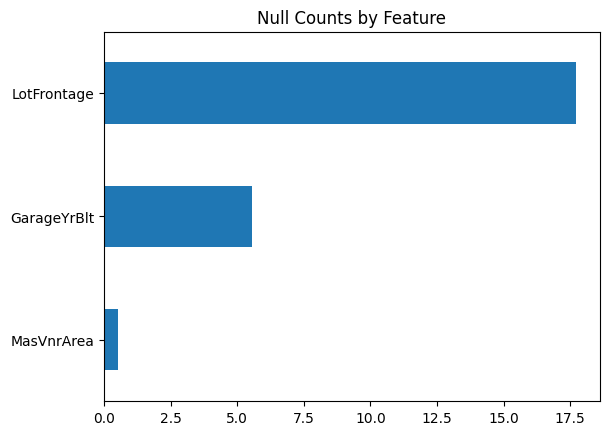

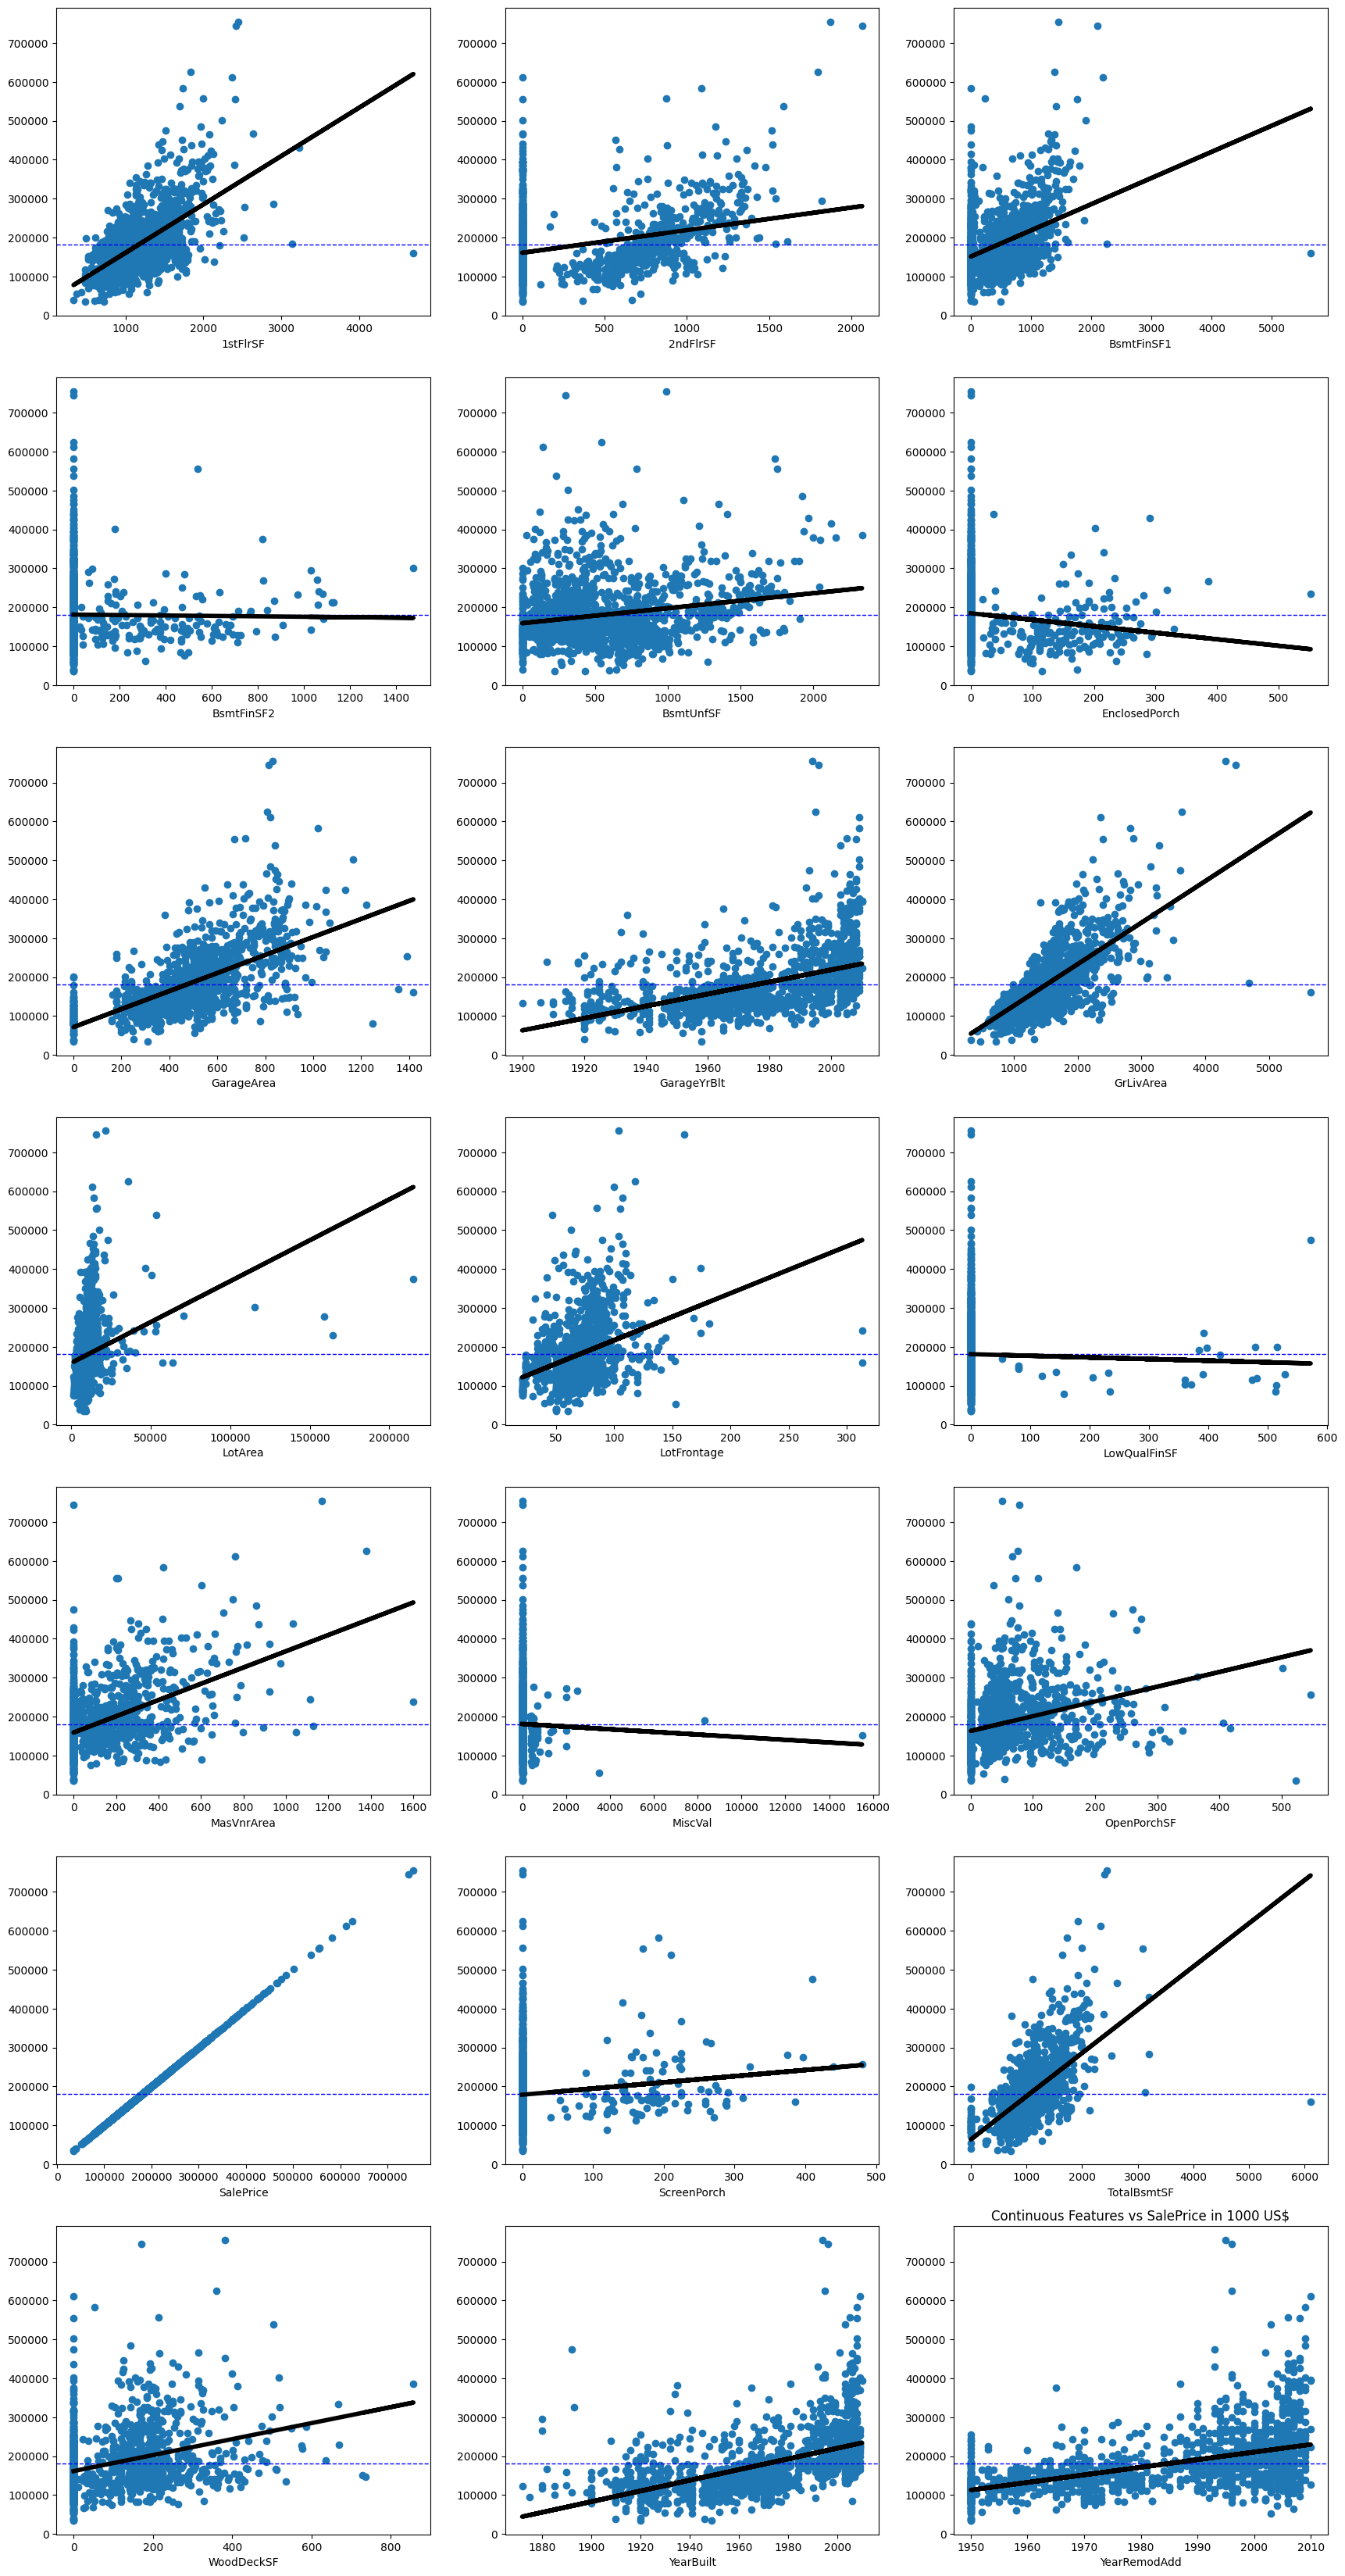

In [125]:
def analyze_continuous_numeric_features(dataframe, min_unique_values=21):
    print (f"Analyzing continuous numeric features (at least {min_unique_values} unique values)")

    df_num = dataframe.select_dtypes(include=[np.number])  # Select only numeric features
    df_num_continuous = df_num[[col for col in df_num.columns if df_num[col].nunique() >= min_unique_values]]      # Continuout numeric features (has a large number of values)
    df_num_continuous = df_num_continuous.reindex(sorted(df_num_continuous.columns), axis=1)      # Alphebetize columns for the plots below

    show_nulls(df_num_continuous)

    # For each feature in df_num_continuous, plot the feature value vs the SalePrice
    print (f"Scatter plot of continuous numeric features vs {label}")
    ncols = 3
    nrows = int(np.ceil(len(df_num_continuous.columns)/ncols))
    _, axes = plt.subplots(nrows, ncols, figsize=(ncols*7, nrows*6))
    for i, feature in enumerate(df_num_continuous.columns):
        if nrows == 1:
            ax = axes[i]
        else:
            ax = axes[i//ncols, i%ncols]
        # Create a scatter plot of feature vs SalePrice
        ax.scatter(dataframe[feature], dataframe[label])
        ax.set_xlabel(feature)

        # Show the (common) mean sales price
        ax.axhline(dataframe[label].mean(), color='blue', linestyle='dashed', linewidth=1) # Median price

        if feature == label:
            continue
    
        # Show the (graph-specific) trend line
        try:
            df = dataframe[[feature, label]].dropna()
            m, b = np.polyfit(df[feature], df[label], 1)
            x = df[feature].unique()
            ax.plot(x, m*x + b, color='black', linewidth=4) # Trend line
        except Exception as e:
            print (f"Couldn't plot trend line for {feature}; {e}")

    plt.title ("Continuous Features vs SalePrice in 1000 US$")
    plt.show()

analyze_continuous_numeric_features (df)


## Categorical data analysis

Observations:
* These should dropped: Alley, BldgType, BsmtFinType2, Electrical, Fence, Heating, MiscFeature, PoolQC, RoofMatl, RoofStyle, Street, Utilities
* These are candidates for label encoding (ordered values that seem to correspond to price); BsmtCond, BsmtExposure, BsmtQual, BsmtFinType1, ExterCond, ExterQual, FireplaceQu, Functional (although almost everything is "Typ" so maybe drop), GarageCond, GarageFinish, GarageQual, HeatingQC, KitchenQual
* These are candiates for one-hot-encoding just a single value:
** CentralAir = Y
** GarageType = builtin
** PavedDrive = Y (not enough nos that this is a priority)
** SaleType = New
** SaleCondition = Partial (although this may be due to SaleType, so might just drop this)
** Utilities = AllPub
* These are candidates for full one-hot encoding; Neighborhood (although possible to label encode to good/bad/medium?), MasVnrType
* Others are less clear; needs more thought to decide if best to drop or use:
* Condition1, Condition2, RoofStyle, Exterior1st, Exterior2nd, Foundation, HousingStyle, LandContour, LandSlope, LotConfig (or pick out CulDSac?), LotShape, MSZoning (or pick out commercial FV/RL?))

Analyzing categorical features
Percent nulls per feature (out of 1460 samples):
PoolQC          99.52
MiscFeature     96.30
Alley           93.76
Fence           80.75
MasVnrType      59.72
FireplaceQu     47.26
GarageCond       5.54
GarageFinish     5.54
GarageQual       5.54
GarageType       5.54
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtCond         2.53
BsmtFinType1     2.53
BsmtQual         2.53
Electrical       0.06
dtype: float64
nrows: 15, ncols: 3, len(df_cat.columns): 43


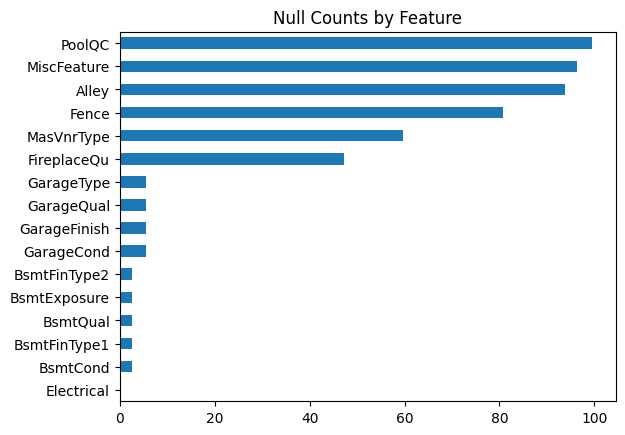

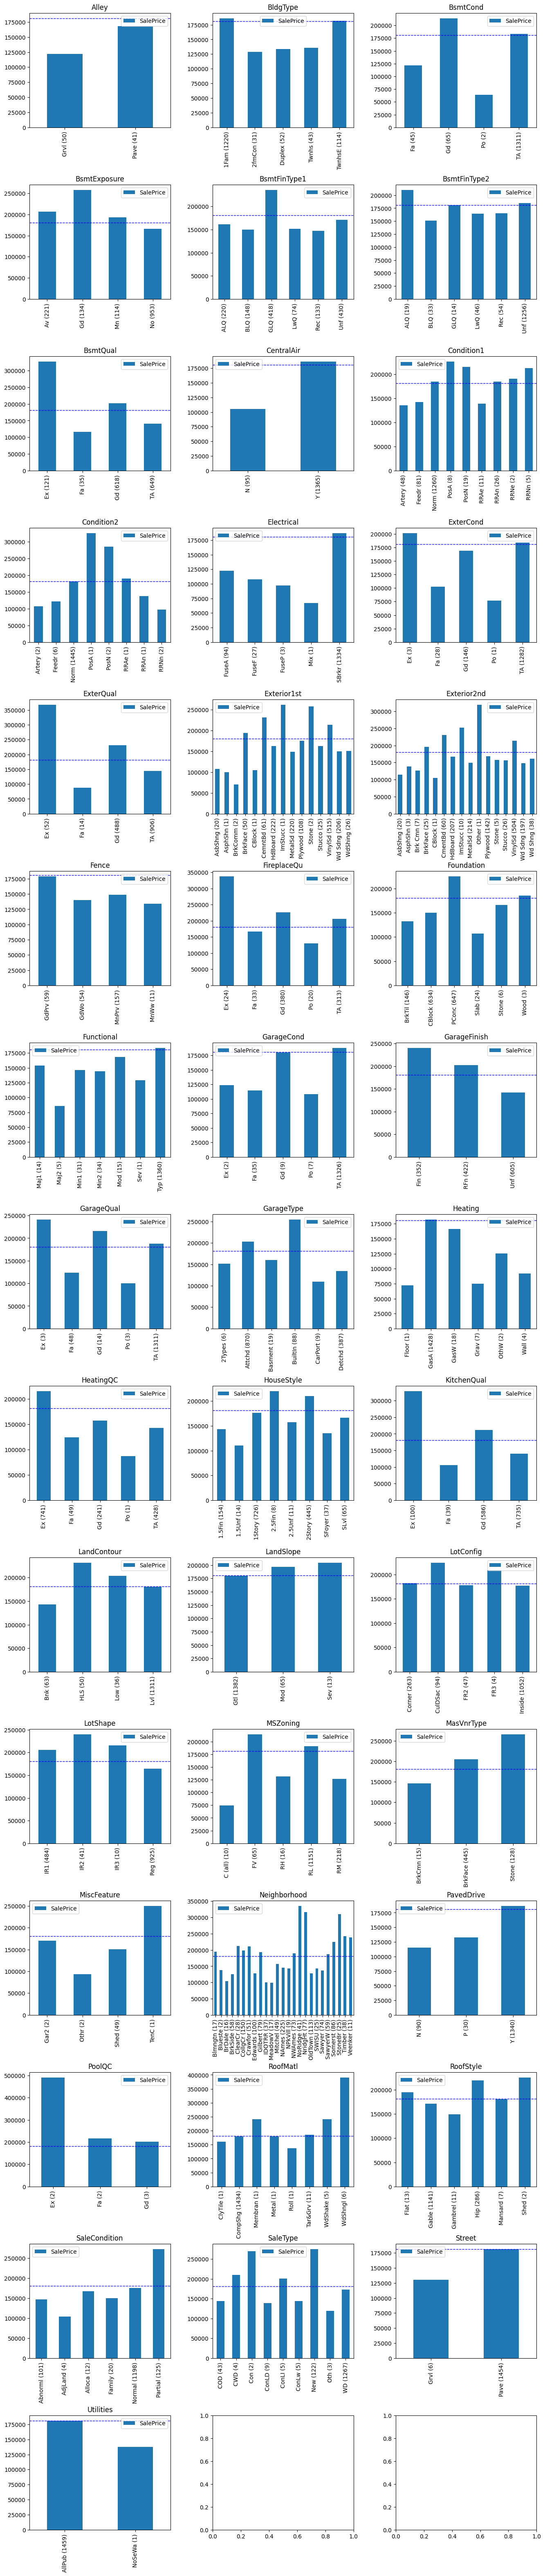

In [126]:
def analyze_categorical_features(dataframe):
    print ("Analyzing categorical features")

    df_cat = dataframe.select_dtypes(include=['object'])   # Categorical features
    df_cat = df_cat.reindex(sorted(df_cat.columns), axis=1)      # Alphebetize columns for the plots below

    show_nulls(df_cat)

    ncols = 3
    nrows = int(np.ceil((len(df_cat.columns))/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 80))
    # Add spacing between plots
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    print (f"nrows: {nrows}, ncols: {ncols}, len(df_cat.columns): {len(df_cat.columns)}")
    for i, feature in enumerate(df_cat.columns):
        if nrows == 1:
            ax = axes[i]
        else:
            ax = axes[i//ncols, i%ncols]
        price_by_cat = df[[feature, label]].groupby(feature).mean()
        price_by_cat.plot.bar(ax=ax)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title(feature)

        # Draw a horizontal line showing the mean price
        ax.axhline(df[label].mean(), color='blue', linestyle='dashed', linewidth=1)

        # Show the number of samples in each category
        counts = df[feature].value_counts()
        xlables = []
        for i in range(len(price_by_cat.index)):
            value = price_by_cat.index[i]
            count = counts[value]
            xlables.append(f"{value} ({count})")
        ax.set_xticklabels(xlables, rotation=90)
    plt.show()

analyze_categorical_features(df)


## Manufactured features

Analyzing continuous numeric features (at least 0 unique values)
No nulls found
Scatter plot of continuous numeric features vs SalePrice


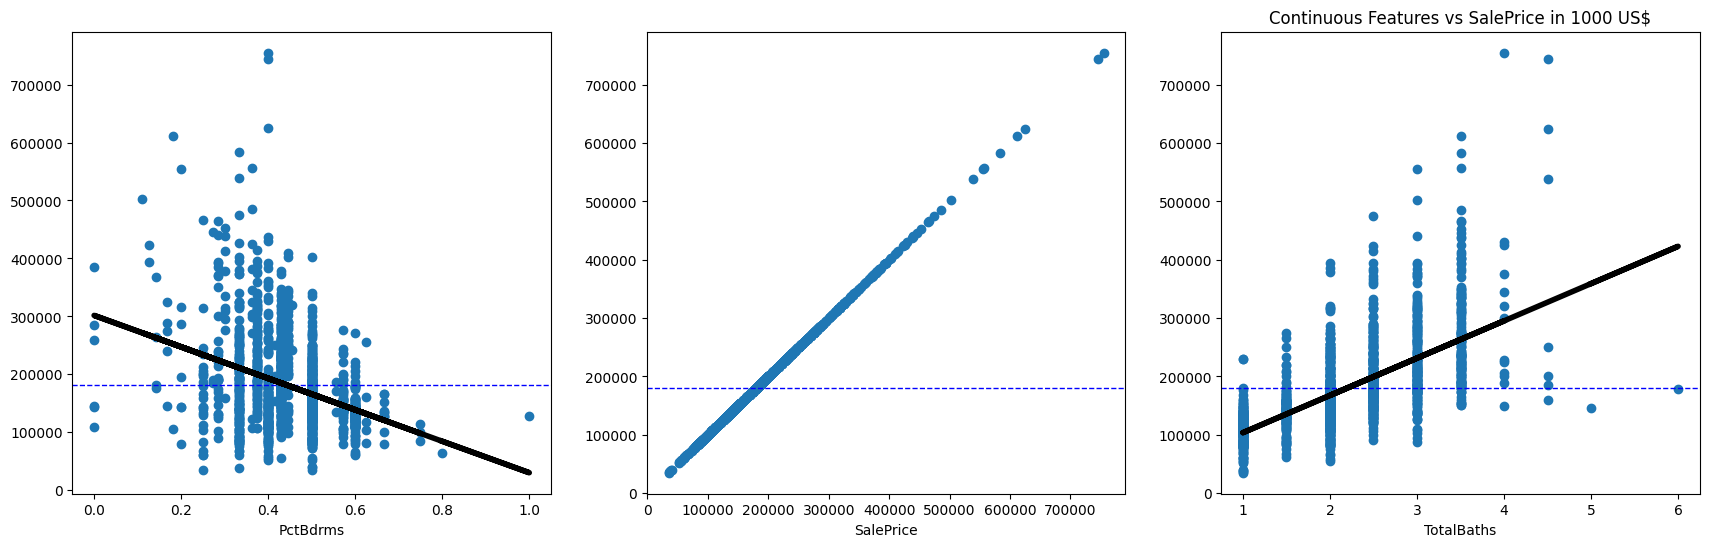

count    1201.000000
mean        0.007902
std         0.002424
min         0.000697
25%         0.006667
50%         0.007715
75%         0.008649
max         0.037154
Name: LotFrontageToAreaRatio, dtype: float64
count    1201.000000
mean        0.015803
std         0.004849
min         0.001394
25%         0.013333
50%         0.015429
75%         0.017297
max         0.074308
Name: LotFrontageToAreaRatio, dtype: float64


In [131]:
df2 = pd.DataFrame()
df2[label] = df["SalePrice"]
df2["TotalBaths"] = df["FullBath"] + .5* df["HalfBath"] + df["BsmtFullBath"] + .5 * df["BsmtHalfBath"]  # Seems to be a better predictor
df2["PctBdrms"] = df["BedroomAbvGr"] / df["TotRmsAbvGrd"]  # Seems to be a better predictor than BedroomAbvGr
analyze_continuous_numeric_features(df2, 0)

# Print a histogram of the ratio LotFrontage to LotArea*2
df2["LotFrontageToAreaRatio"] = df["LotFrontage"] / (df["LotArea"])
print (df2["LotFrontageToAreaRatio"].describe())
df2["LotFrontageToAreaRatio"] = df["LotFrontage"] / (df["LotArea"]*.5)
print (df2["LotFrontageToAreaRatio"].describe())
